# Deep Residual Learning for Image Recognition (2016)
## Satellite Image Classification with RSI-CB256 dataset and PyTorch

In [2]:
import os
import random
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
#import torchvision.transforms as tt
from torchvision.transforms import v2
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import randrange
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'
#from torchvision import datasets, transforms, models
from torchvision import datasets, models
from torchinfo import summary


In [2]:
#data_dir = '/g/data/wb00/admin/testing/kaggle/data'
data_dir = "/g/data/wb00/admin/testing/nci-dl-train-dataset/RSI-CB256-dataset/" 
folders = os.listdir(data_dir)
#print(folders)

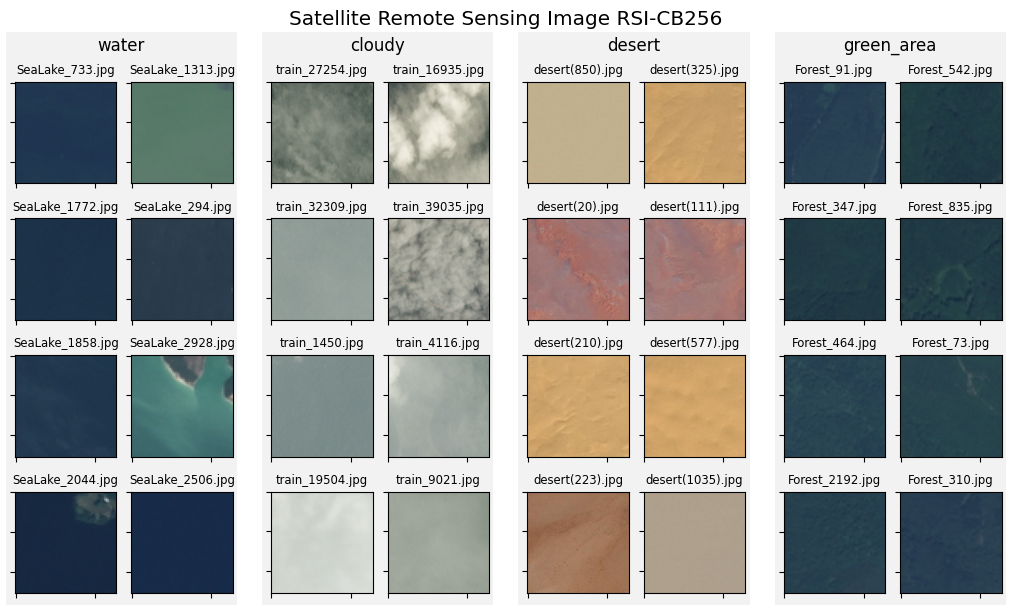

In [3]:
fig = plt.figure(layout='constrained', figsize=(10, 6))
subfigs = fig.subfigures(1, 4, wspace=0.1)

def get_random_img(path):   
    random_file = random.choice(os.listdir(path))
    #print(os.path.join (path, random_file))
    return random_file, mpimg.imread(os.path.join (path, random_file) )

for i, subfig in enumerate(subfigs):
    axs = subfig.subplots(4, 2)
    subfig.set_facecolor('0.95')
    for ax in axs :
        for ax2 in ax :
            name, img = get_random_img(f'{data_dir}/{folders[i]}/')
            ax2.imshow(img)
            ax2.set_title(name, fontsize='small')
            ax2.set_xticklabels([])
            ax2.set_yticklabels([])
            #plt.subplots_adjust(wspace=0.1, hspace=0.1)
    subfig.suptitle(folders[i], fontsize='large')
    
fig.suptitle('Satellite Remote Sensing Image RSI-CB256', fontsize='x-large')
plt.show()        

# Data transforms (normalization & data augmentation)

In [4]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_transforms = v2.Compose([v2.Resize(64),
                               v2.ToImage(),
                               v2.ToDtype(torch.float32, scale=True), 
                               v2.Normalize(mean=(0.4914, 0.4822, 0.4465) , std=(0.2023, 0.1994, 0.2010) )
                                       ])
test_transforms = v2.Compose([v2.Resize(64),
                               v2.ToImage(),
                               v2.ToDtype(torch.float32, scale=True), 
                               v2.Normalize(mean=(0.4914, 0.4822, 0.4465) , std=(0.2023, 0.1994, 0.2010) )
                                      ])

train_data = datasets.ImageFolder(data_dir,       
                    transform=train_transforms)
test_data = datasets.ImageFolder(data_dir,
                    transform=test_transforms)

In [5]:
batch_size = 8

# Loading the data intp data loaders!

In [6]:
# PyTorch data loaders
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(test_data, batch_size*2, num_workers=2, pin_memory=True)

In [7]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        #ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

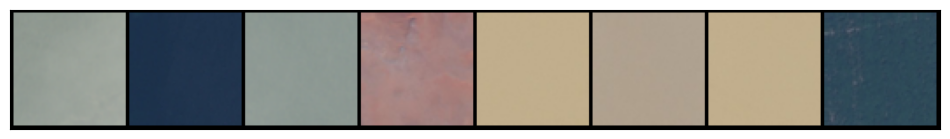

In [8]:
show_batch(train_dl)

# Using a GPU

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Simple Residual Block Example

In [12]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [13]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([8, 3, 64, 64])


## Helper Functions

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

## Model

In [15]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [16]:
model = to_device(ResNet9(3, 4), device)
summary(model)

Layer (type:depth-idx)                   Param #
ResNet9                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       73,856
│    └─BatchNorm2d: 2-5                  256
│    └─ReLU: 2-6                         --
│    └─MaxPool2d: 2-7                    --
├─Sequential: 1-3                        --
│    └─Sequential: 2-8                   --
│    │    └─Conv2d: 3-1                  147,584
│    │    └─BatchNorm2d: 3-2             256
│    │    └─ReLU: 3-3                    --
│    └─Sequential: 2-9                   --
│    │    └─Conv2d: 3-4                  147,584
│    │    └─BatchNorm2d: 3-5             256
│    │    └─ReLU: 3-6                    --
├─Sequential: 1-4                        --
│    └─Conv2d: 2-10                      295,168
│

# Training Loop

In [17]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Evaluating the model

In [18]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 1.88 s, sys: 341 ms, total: 2.23 s
Wall time: 4.15 s


[{'val_loss': 1.3919048309326172, 'val_acc': 0.26651278138160706}]

## Train 

In [19]:
epochs = 50
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [20]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00050, train_loss: 0.6514, val_loss: 0.2528, val_acc: 0.9069
Epoch [1], last_lr: 0.00081, train_loss: 0.4163, val_loss: 0.8783, val_acc: 0.7368
Epoch [2], last_lr: 0.00132, train_loss: 0.3901, val_loss: 0.7135, val_acc: 0.7941
Epoch [3], last_lr: 0.00199, train_loss: 0.3982, val_loss: 1.0819, val_acc: 0.7222
Epoch [4], last_lr: 0.00280, train_loss: 0.4618, val_loss: 0.5865, val_acc: 0.7825
Epoch [5], last_lr: 0.00372, train_loss: 0.4667, val_loss: 0.9211, val_acc: 0.7401
Epoch [6], last_lr: 0.00470, train_loss: 0.4733, val_loss: 1.0178, val_acc: 0.6899
Epoch [7], last_lr: 0.00570, train_loss: 0.4302, val_loss: 0.5353, val_acc: 0.7995
Epoch [8], last_lr: 0.00668, train_loss: 0.3828, val_loss: 0.8444, val_acc: 0.7377
Epoch [9], last_lr: 0.00760, train_loss: 0.3740, val_loss: 0.1808, val_acc: 0.9476
Epoch [10], last_lr: 0.00841, train_loss: 0.3444, val_loss: 0.4839, val_acc: 0.8427
Epoch [11], last_lr: 0.00908, train_loss: 0.3296, val_loss: 0.1856, val_acc: 0.9254
Ep

## Visualize 

In [21]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

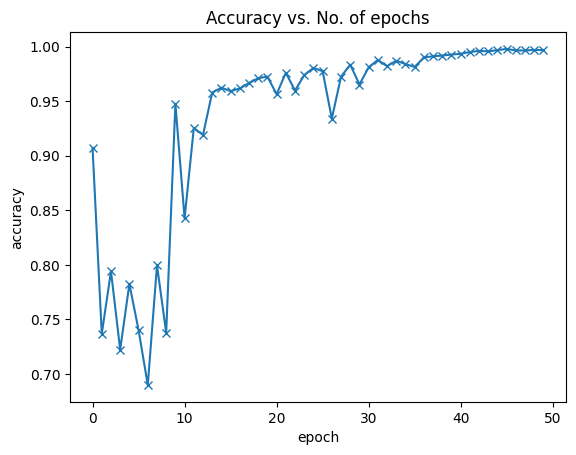

In [22]:
plot_accuracies(history)

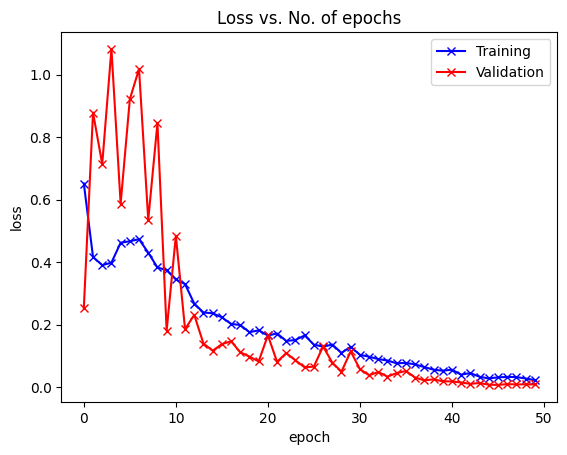

In [23]:
plot_losses(history)

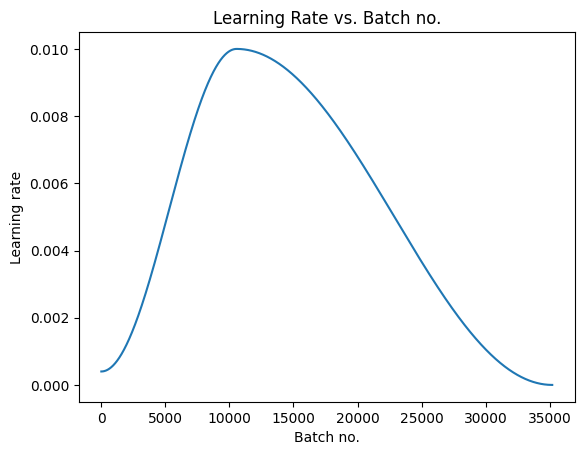

In [24]:
plot_lrs(history)

# Testing with Image Batches

In [25]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_data.classes[preds[0].item()]

In [26]:
def test_run():  
    xfig, axs = plt.subplots(2, 5, figsize=(15, 6))
    test_data_len = len(test_data)
    for row_axs in axs:
        for ax in row_axs:
            img, label = test_data[ randrange(test_data_len) ]
            denorm_img = denormalize(img, *stats)
            #ax.imshow(img.permute(1, 2, 0).clamp(0, 1))
            ax.imshow(denorm_img[0].permute(1, 2, 0).clamp(0, 1))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            pred_label = predict_image(img, model)
            train_label= train_data.classes[label] 
            if (pred_label==train_label):
                fg_color = 'green'
            else:
                fg_color = 'red'
            ax.set_title (f'Label: {train_label}\n Pred: {pred_label}' , 
                          fontsize='large', color=fg_color)

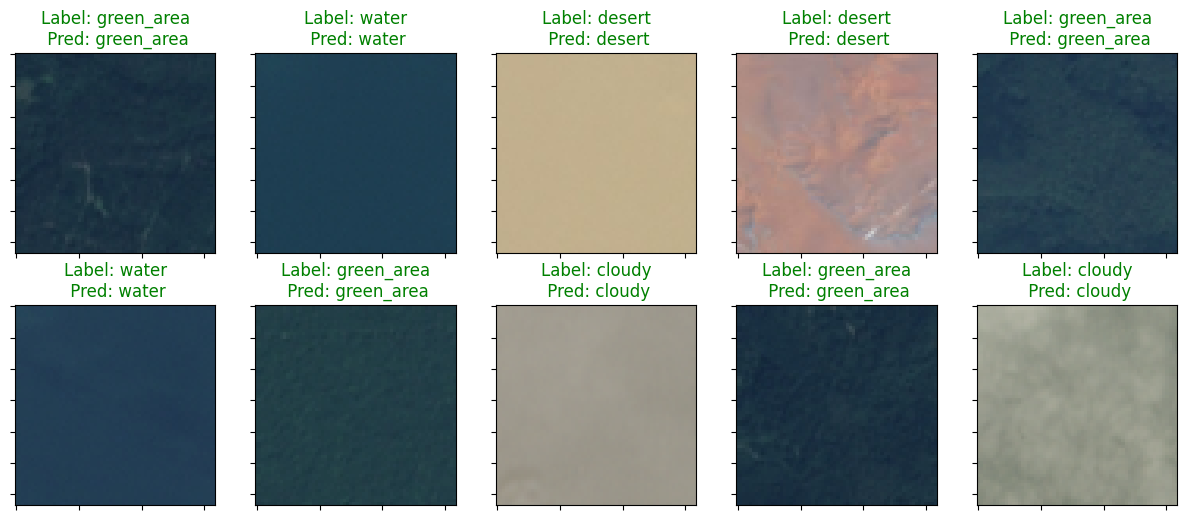

In [27]:
test_run()